Beer3 Positive Results
==============

1. LDA
-------

In [145]:
from lda_for_fragments import run_lda
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [146]:
n_topics = 50
n_samples = 500

**Features.**

For each document (i.e. parent peak), we have the following bag-of-words of features:
1. The discretised m/z value of its fragment peaks. For the value, we use the the logged intensity of the fragment peak, scaled from 0..100.
2. The discretised m/z value of neutral losses. For the value, we use the log intensity of the neutral loss peak, scaled from 0..100.
3. The discretised m/z differences between each pair of fragment peaks. For the value, we use the count of occurences of such m/z differences (e.g. 1, 2, 3), scaled from 0..100.

A lot of heuristics (thresholding, etc). were used when extracting these features from the mzXML files. See extractFeatures.R for more details.

The discretisation step we use to prerocess the input before passing it to the model seems quite dodgy now. We see in the histogram below the tall bars at bin=10, 20 and 30. These come from (3) above. The rest of the histogram bins come from (1) and (2).

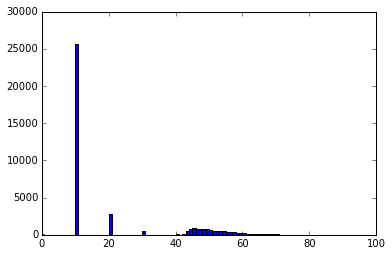

bin=0 count=0.0
bin=1 count=0.0
bin=2 count=0.0
bin=3 count=0.0
bin=4 count=0.0
bin=5 count=0.0
bin=6 count=0.0
bin=7 count=0.0
bin=8 count=0.0
bin=9 count=0.0
bin=10 count=25649.0
bin=11 count=0.0
bin=12 count=0.0
bin=13 count=0.0
bin=14 count=0.0
bin=15 count=0.0
bin=16 count=0.0
bin=17 count=0.0
bin=18 count=0.0
bin=19 count=0.0
bin=20 count=2771.0
bin=21 count=0.0
bin=22 count=0.0
bin=23 count=0.0
bin=24 count=0.0
bin=25 count=0.0
bin=26 count=0.0
bin=27 count=0.0
bin=28 count=0.0
bin=29 count=0.0
bin=30 count=554.0
bin=31 count=0.0
bin=32 count=0.0
bin=33 count=0.0
bin=34 count=0.0
bin=35 count=0.0
bin=36 count=0.0
bin=37 count=0.0
bin=38 count=0.0
bin=39 count=0.0
bin=40 count=135.0
bin=41 count=0.0
bin=42 count=109.0
bin=43 count=554.0
bin=44 count=829.0
bin=45 count=882.0
bin=46 count=804.0
bin=47 count=821.0
bin=48 count=802.0
bin=49 count=753.0
bin=50 count=656.0
bin=51 count=555.0
bin=52 count=474.0
bin=53 count=455.0
bin=54 count=461.0
bin=55 count=412.0
bin=56 count=334.0


In [ ]:
data, model, topicdf, docdf = run_lda('beer3_pos', 
                         'input/Beer_3_T10_POS_fragments.csv', 
                         'input/Beer_3_T10_POS_losses.csv', 
                         'input/Beer_3_T10_POS_mzdiffs.csv', 
                         n_topics, n_samples)

LDA results can be found in the three files generated above.

2. PCA
-------

Here we use PCA to project the topics to lower-dimensional space for visualisation purposes. First ensure the variables are scaled.

In [ ]:
from sklearn import preprocessing
# df = docdf # topics x documents matrix
df = topicdf.transpose() # topics x words matrix
print df.shape

# normalise and scale the variables
scaled_mat = preprocessing.scale(df, axis=0)
# print scaled_mat.mean(axis=0)
# print scaled_mat.std(axis=0)

Then run PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(scaled_mat)
X_r = pca.transform(scaled_mat)

But the explained variances by the first two principal components are too low ..??

In [ ]:
print X_r.shape
print('explained variance by the first two principal components: %s' % str(pca.explained_variance_ratio_))

In [ ]:
plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1])
plt.xlabel('1st princomp')
plt.ylabel('2nd princomp')
plt.title('Projected topics')

3. Network
------------

We can try to put the topics on a network too.

In [ ]:
df = topicdf.transpose()
print df.shape # df is the topic x terms matrix

In [ ]:
# create adjacency matrix A

# first compute euclidean distance between the topics
from scipy.spatial.distance import cdist
A = cdist(scaled_mat, scaled_mat, 'euclidean')

# crudely convert to similarities
maxval = A.max()
A = 1-(A/maxval)
plt.hist(A)

# set a threshold of 0.3 for the similarity values for the network graph
for i in xrange(A.shape[0]):
    for j in xrange(A.shape[1]):
        if A[i, j] < 0.40:
            A[i, j] = 0

plt.matshow(A)
plt.colorbar()
plt.show()

In [ ]:
import networkx as nx
from networkx.readwrite import json_graph
dt = [('len', float)]
A = A.view(dt)
G = nx.from_numpy_matrix(A)
pos = nx.spring_layout(G, k=0.3, iterations=20)
nx.draw(G,pos,font_size=8)

Hard to conclude antyhing .... It seems like there are some 'core' topics that the rest are connected to (in the high-dimensional Euclidean space). However, take note the network graph above can be misleading due to the thresholding values used.

4. Topics
-----------

Visualise the document-topic distributions

In [ ]:
df = docdf.transpose()
print df.shape
plt.pcolor(df, norm=None, cmap='Blues')
plt.tight_layout()
plt.xlabel('Topics')
plt.ylabel('Parent peaks')
plt.title('Documents-topics distributions')
plt.show()

For every topic, check the words inside.

In [ ]:
n_docs = 10
n_fragments = 20

topic_fragments = model.topic_word_
headers = list(docdf.columns.values)

for i, topic_dist in enumerate(topic_fragments):
    
    print "Topic " + str(i)
    print "=========="
    print
    
    column_values = np.array(docdf.columns.values)    
    doc_dist = docdf.iloc[[i]].as_matrix().flatten()
    idx = np.argsort(doc_dist)[::-1] # argsort in descending order
    topic_d = np.array(column_values)[idx]
    topic_p = np.array(doc_dist)[idx]
    top_n_docs = topic_d[1:n_docs]
    top_n_docs_p = topic_p[1:n_docs]
    
    print "Parent peaks"
    print "\n".join(' - %s\t%.3f' % t for t in zip(top_n_docs, top_n_docs_p))

    column_values = np.array(data.columns.values)
    idx = np.argsort(topic_dist)[::-1] # argsort in descending order
    topic_w = np.array(column_values)[idx]
    topic_p = np.array(topic_dist)[idx]    
    fragments = []
    fragments_p = []
    others = []
    others_p = []
    for w, p in zip(topic_w, topic_p):
        if len(fragments) > n_fragments:
            break
        if w.startswith('fragment'):
            fragments.append(w)
            fragments_p.append(p)
        else:
            others.append(w)
            others_p.append(p)

    print "Fragments"
    print "\n".join(' - %s\t%.3f' % t for t in zip(fragments, fragments_p))

    print "Others"
    print "\n".join(' - %-15s\t%.3f' % t for t in zip(others, others_p))
    print

make a plot (plus the intensity) from the report above ...

5. No. of Topics
-------------------

Compute the held-out perplexity on the testing set and plot as the no. of topics is increased ..